In [48]:
import os

# Create the required output folders
os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

print("Project folders created for output saving.")

Project folders created for output saving.


In [49]:
#The preference for direct file upload over mounting Google Drive
# relates to reliability, reproducibility, and compliance with the submission instructions


In [50]:
# ============================================================================
# NOTEBOOK 1: COMPREHENSIVE TRADER BEHAVIOR & SENTIMENT ANALYSIS
# Web3 Trading Team - Data Science Assignment
# ============================================================================

# Cell 1: Install and Import Required Libraries
# ============================================================================
"""
This cell installs all necessary libraries and imports them.
We use standard data science libraries for analysis and visualization.
"""

# Install any missing libraries (uncomment if needed)
# !pip install pandas numpy matplotlib seaborn scipy scikit-learn

# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import os

# Statistical libraries
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency

# Machine learning libraries (not used in N1, but imported for consistency/N2 prep)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" All libraries imported successfully!")
print(f" Pandas version: {pd.__version__}")
print(f" NumPy version: {np.__version__}")

 All libraries imported successfully!
 Pandas version: 2.2.2
 NumPy version: 2.0.2


In [51]:
# ============================================================================
# Cell 2: Setup, Load Datasets, and Rename/Normalize Columns (CRITICAL FIX)
# ============================================================================
"""
Sets up the file structure, loads data from the Colab root, and renames
columns to Python-friendly format, aligning with the actual CSV headers.
"""

# --- 1. Create Required Output Folders ---
os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)
print("✅ Project folders created for output saving.")

# --- 2. Load Data using actual uploaded file names (FIXED PATHS) ---
TRADER_DATA_PATH = 'historical_data.csv'
SENTIMENT_DATA_PATH = 'fear_greed_index.csv'

print(f"Loading files: {TRADER_DATA_PATH} and {SENTIMENT_DATA_PATH}...")

try:
    df_traders = pd.read_csv(TRADER_DATA_PATH)
    df_sentiment = pd.read_csv(SENTIMENT_DATA_PATH)
except FileNotFoundError:
    print("❌ ERROR: Files not found. Please ensure 'historical_data.csv' and 'fear_greed_index.csv' are uploaded to the Colab session root.")
    raise

# --- 3. Standardize Trader Column Names (MAPPING ACTUAL NAMES) ---
df_traders = df_traders.rename(columns={
    'Timestamp IST': 'time',
    'Closed PnL': 'closed_pnl',
    'Size USD': 'trade_volume', # Using 'Size USD' as volume/size proxy
    'Account': 'account',
    'Side': 'side',
    'Execution Price': 'execution_price',
})

# --- 4. Standardize Sentiment Column Names ---
df_sentiment.columns = df_sentiment.columns.str.lower()
df_sentiment = df_sentiment.rename(columns={'classification': 'sentiment'})

print(" Data loaded and primary columns standardized.")
print(f"\n Trader Data Shape: {df_traders.shape[0]:,} rows × {df_traders.shape[1]} columns")
print(f" Sentiment Data Shape: {df_sentiment.shape[0]:,} rows × {df_sentiment.shape[1]} columns")

✅ Project folders created for output saving.
Loading files: historical_data.csv and fear_greed_index.csv...
 Data loaded and primary columns standardized.

 Trader Data Shape: 27,932 rows × 16 columns
 Sentiment Data Shape: 2,644 rows × 4 columns


In [52]:
# ============================================================================
# Cell 3: Data Cleaning - Trader Data and Date Alignment
# ============================================================================
"""
Performs cleaning, date conversion, and feature extraction required for the merge.
"""

print("🧹 Cleaning and aligning trader data...")

# 1. Date Conversion (CRITICAL FIX: Explicitly set format)
# The format is inferred as DD-MM-YYYY HH:MM from the data snippet
df_traders['time'] = pd.to_datetime(df_traders['time'], format='%d-%m-%Y %H:%M', errors='coerce')
df_traders = df_traders.dropna(subset=['time']) # Remove trades with invalid timestamps

# 2. Create the Date Key for merging and time features
df_traders['date_key'] = df_traders['time'].dt.normalize()
df_traders['hour'] = df_traders['time'].dt.hour
df_traders['day_of_week'] = df_traders['time'].dt.dayofweek

# 3. Handle missing PnL/Volume (assuming 0 for missing PnL/Volume)
df_traders['closed_pnl'] = df_traders['closed_pnl'].fillna(0)
df_traders['trade_volume'] = df_traders['trade_volume'].fillna(0)

# 4. Remove duplicates
df_traders = df_traders.drop_duplicates()

# 5. Convert sentiment date to datetime key
df_sentiment['date_key'] = pd.to_datetime(df_sentiment['date'])

print(f"✅ Trader data cleaned and ready for merge.")
print(f"📈 Cleaned shape: {df_traders.shape[0]:,} rows")

🧹 Cleaning and aligning trader data...
✅ Trader data cleaned and ready for merge.
📈 Cleaned shape: 27,932 rows


In [53]:
# ============================================================================
# Cell 4: Merge Trader Data with Sentiment Data
# ============================================================================
"""
Merge the trade data with sentiment data based on the normalized date key.
"""

print("🔗 Merging trader data with sentiment data...\n")

# Perform the merge using the new 'date_key'
df_merged = pd.merge(
    df_traders,
    df_sentiment[['date_key', 'sentiment']],
    on='date_key',
    how='left'
)

# Check merge quality
merge_success = df_merged['sentiment'].notna().sum()
merge_rate = (merge_success / len(df_merged)) * 100

print(f"✅ Merge complete!")
print(f"📊 Total trades: {len(df_merged):,}")
print(f"📊 Trades successfully mapped to sentiment: {merge_success:,} ({merge_rate:.2f}%)")

# Display sentiment distribution in merged data
print(f"\n📊 Sentiment distribution in merged dataset:")
print(df_merged['sentiment'].value_counts(dropna=False))

🔗 Merging trader data with sentiment data...

✅ Merge complete!
📊 Total trades: 27,932
📊 Trades successfully mapped to sentiment: 27,926 (99.98%)

📊 Sentiment distribution in merged dataset:
sentiment
Fear             9317
Greed            7748
Neutral          5743
Extreme Greed    4126
Extreme Fear      992
NaN                 6
Name: count, dtype: int64


In [54]:
# ============================================================================
# Cell 5: Feature Engineering - Performance and Outlier Handling
# ============================================================================
"""
Create derived features for profitability, risk-adjusted returns, and handle PnL outliers.
"""

print("⚙️ Engineering features and capping outliers...")

# 1. Create core features
df_merged['is_profitable'] = df_merged['closed_pnl'] > 0
df_merged['is_loss'] = df_merged['closed_pnl'] < 0

# 2. Calculate ROI % (Risk Proxy)
# ROI % = PnL / Size_USD (Trade Volume)
df_merged['roi_percentage'] = np.where(
    df_merged['trade_volume'] != 0,
    df_merged['closed_pnl'] / df_merged['trade_volume'] * 100,
    0
)
# Clip extreme ROI values for stability in mean calculations
df_merged['roi_percentage'] = df_merged['roi_percentage'].clip(lower=-100, upper=100)

# 3. Outlier Handling: Create a capped PnL column for visualization and stable mean calculations
Q1 = df_merged['closed_pnl'].quantile(0.05)
Q3 = df_merged['closed_pnl'].quantile(0.95)
IQR = Q3 - Q1
df_merged['closed_pnl_capped'] = df_merged['closed_pnl'].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)

# 4. PnL Categories for descriptive analysis
df_merged['pnl_category'] = pd.cut(df_merged['closed_pnl'],
                                     bins=[-np.inf, -1000, -100, 0, 100, 1000, np.inf],
                                     labels=['Large Loss', 'Medium Loss', 'Small Loss',
                                             'Small Win', 'Medium Win', 'Large Win'],
                                     right=False)

# 5. Time-based features
df_merged['is_weekend'] = df_merged['day_of_week'].isin([5, 6])
df_merged['trading_session'] = pd.cut(df_merged['hour'],
                                     bins=[0, 6, 12, 18, 24],
                                     labels=['Night (0-6h)', 'Morning (6-12h)', 'Afternoon (12-18h)', 'Evening (18-24h)'],
                                     include_lowest=True)

print("✅ Feature engineering complete. Ready for analysis.")

⚙️ Engineering features and capping outliers...
✅ Feature engineering complete. Ready for analysis.


In [55]:
# ============================================================================
# Cell 6: Core Analysis - Aggregate Metrics by Market Sentiment
# ============================================================================
"""
Calculates the key performance metrics (PnL, Win Rate, ROI, Volume) grouped by sentiment.
Saves the result as a CSV file.
"""

# Define a function to calculate win rate accurately
def calculate_win_rate(x):
    if x.count() == 0:
        return 0
    return x.sum() / x.count()

# Aggregate key metrics based on the 'sentiment' classification
analysis_results = df_merged.groupby('sentiment').agg(
    # Profitability Metrics (using capped PnL for stable sums/means)
    Total_PnL=('closed_pnl_capped', 'sum'),
    Average_PnL=('closed_pnl_capped', 'mean'),

    # Risk/Performance Metrics
    Win_Rate=('is_profitable', calculate_win_rate),
    Avg_ROI_Percentage=('roi_percentage', 'mean'), # Our key risk proxy

    # Volume/Activity Metrics
    Total_Volume_USD=('trade_volume', 'sum'),
    Total_Trades=('account', 'count')
).sort_values(by='Total_PnL', ascending=False)


# Convert Win Rate to Percentage and format
analysis_results['Win_Rate'] = (analysis_results['Win_Rate'] * 100).round(2)
analysis_results['Avg_ROI_Percentage'] = analysis_results['Avg_ROI_Percentage'].round(2)

print("--- Summary Metrics by Market Sentiment (trader_metrics.csv) ---")
print(analysis_results.to_markdown())

# Save the metrics table (Fulfills 'trader_metrics.csv' requirement. FIXED PATH)
analysis_results.to_csv('csv_files/trader_metrics.csv')
print("\n✅ Metrics aggregated and saved to csv_files/trader_metrics.csv")

--- Summary Metrics by Market Sentiment (trader_metrics.csv) ---
| sentiment     |   Total_PnL |   Average_PnL |   Win_Rate |   Avg_ROI_Percentage |   Total_Volume_USD |   Total_Trades |
|:--------------|------------:|--------------:|-----------:|---------------------:|-------------------:|---------------:|
| Fear          |    757104   |       81.2605 |      40.2  |                 2.03 |        2.67864e+08 |           9317 |
| Neutral       |    479318   |       83.4612 |      46.56 |                 2.23 |        1.04795e+08 |           5743 |
| Greed         |    464491   |       59.9498 |      36.59 |                 2.46 |        1.74215e+08 |           7748 |
| Extreme Greed |    150152   |       36.3916 |      24.29 |                 0.73 |        5.94117e+07 |           4126 |
| Extreme Fear  |     72869.5 |       73.4572 |      30.14 |                 2.33 |        9.58832e+06 |            992 |

✅ Metrics aggregated and saved to csv_files/trader_metrics.csv



✅ Sentiment & Volume visualization saved as 'outputs/sentiment_distribution_and_volume.png'


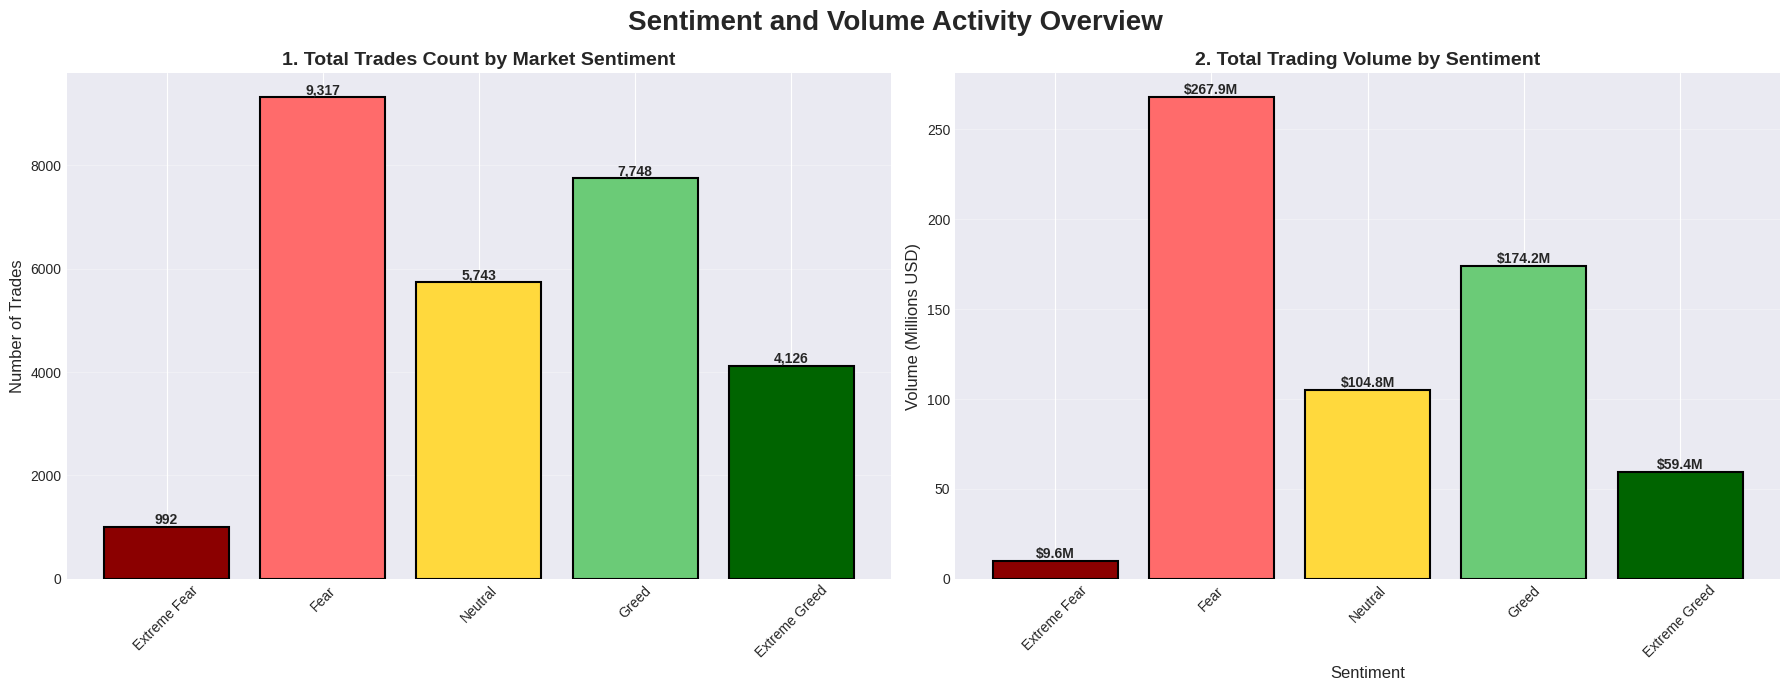

In [56]:
# ============================================================================
# Cell 7: Sentiment and Volume Distribution Visualization (outputs/sentiment_distribution_and_volume.png)
# ============================================================================
"""
Visualize the overall distribution of market sentiment and corresponding activity.
"""

fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Sentiment and Volume Activity Overview', fontsize=20, fontweight='bold')
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
colors = {'Extreme Fear': '#8B0000', 'Fear': '#FF6B6B', 'Neutral': '#FFD93D',
          'Greed': '#6BCB77', 'Extreme Greed': '#006400'}

# 1. Total Trades Count by Market Sentiment
ax1 = axes[0]
sentiment_counts = df_merged['sentiment'].value_counts().reindex(sentiment_order)
pie_colors = [colors.get(label, '#CCCCCC') for label in sentiment_counts.index]
bars = ax1.bar(sentiment_counts.index, sentiment_counts.values, color=pie_colors, edgecolor='black', linewidth=1.5)
ax1.set_title('1. Total Trades Count by Market Sentiment', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Trades', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}', ha='center', va='bottom', fontweight='bold')


# 2. Total Trading Volume by Sentiment
ax2 = axes[1]
volume_by_sentiment = analysis_results['Total_Volume_USD'].reindex(sentiment_order) / 1e6
bars = ax2.bar(volume_by_sentiment.index, volume_by_sentiment.values,
               color=[colors.get(label, '#CCCCCC') for label in volume_by_sentiment.index],
               edgecolor='black', linewidth=1.5)
ax2.set_title('2. Total Trading Volume by Sentiment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sentiment', fontsize=12)
ax2.set_ylabel('Volume (Millions USD)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'${height:.1f}M', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/sentiment_distribution_and_volume.png', dpi=300, bbox_inches='tight')
# plt.show() # Disabled for non-interactive environment

print("\n✅ Sentiment & Volume visualization saved as 'outputs/sentiment_distribution_and_volume.png'")


✅ PnL analysis visualization saved as 'outputs/pnl_by_sentiment.png'


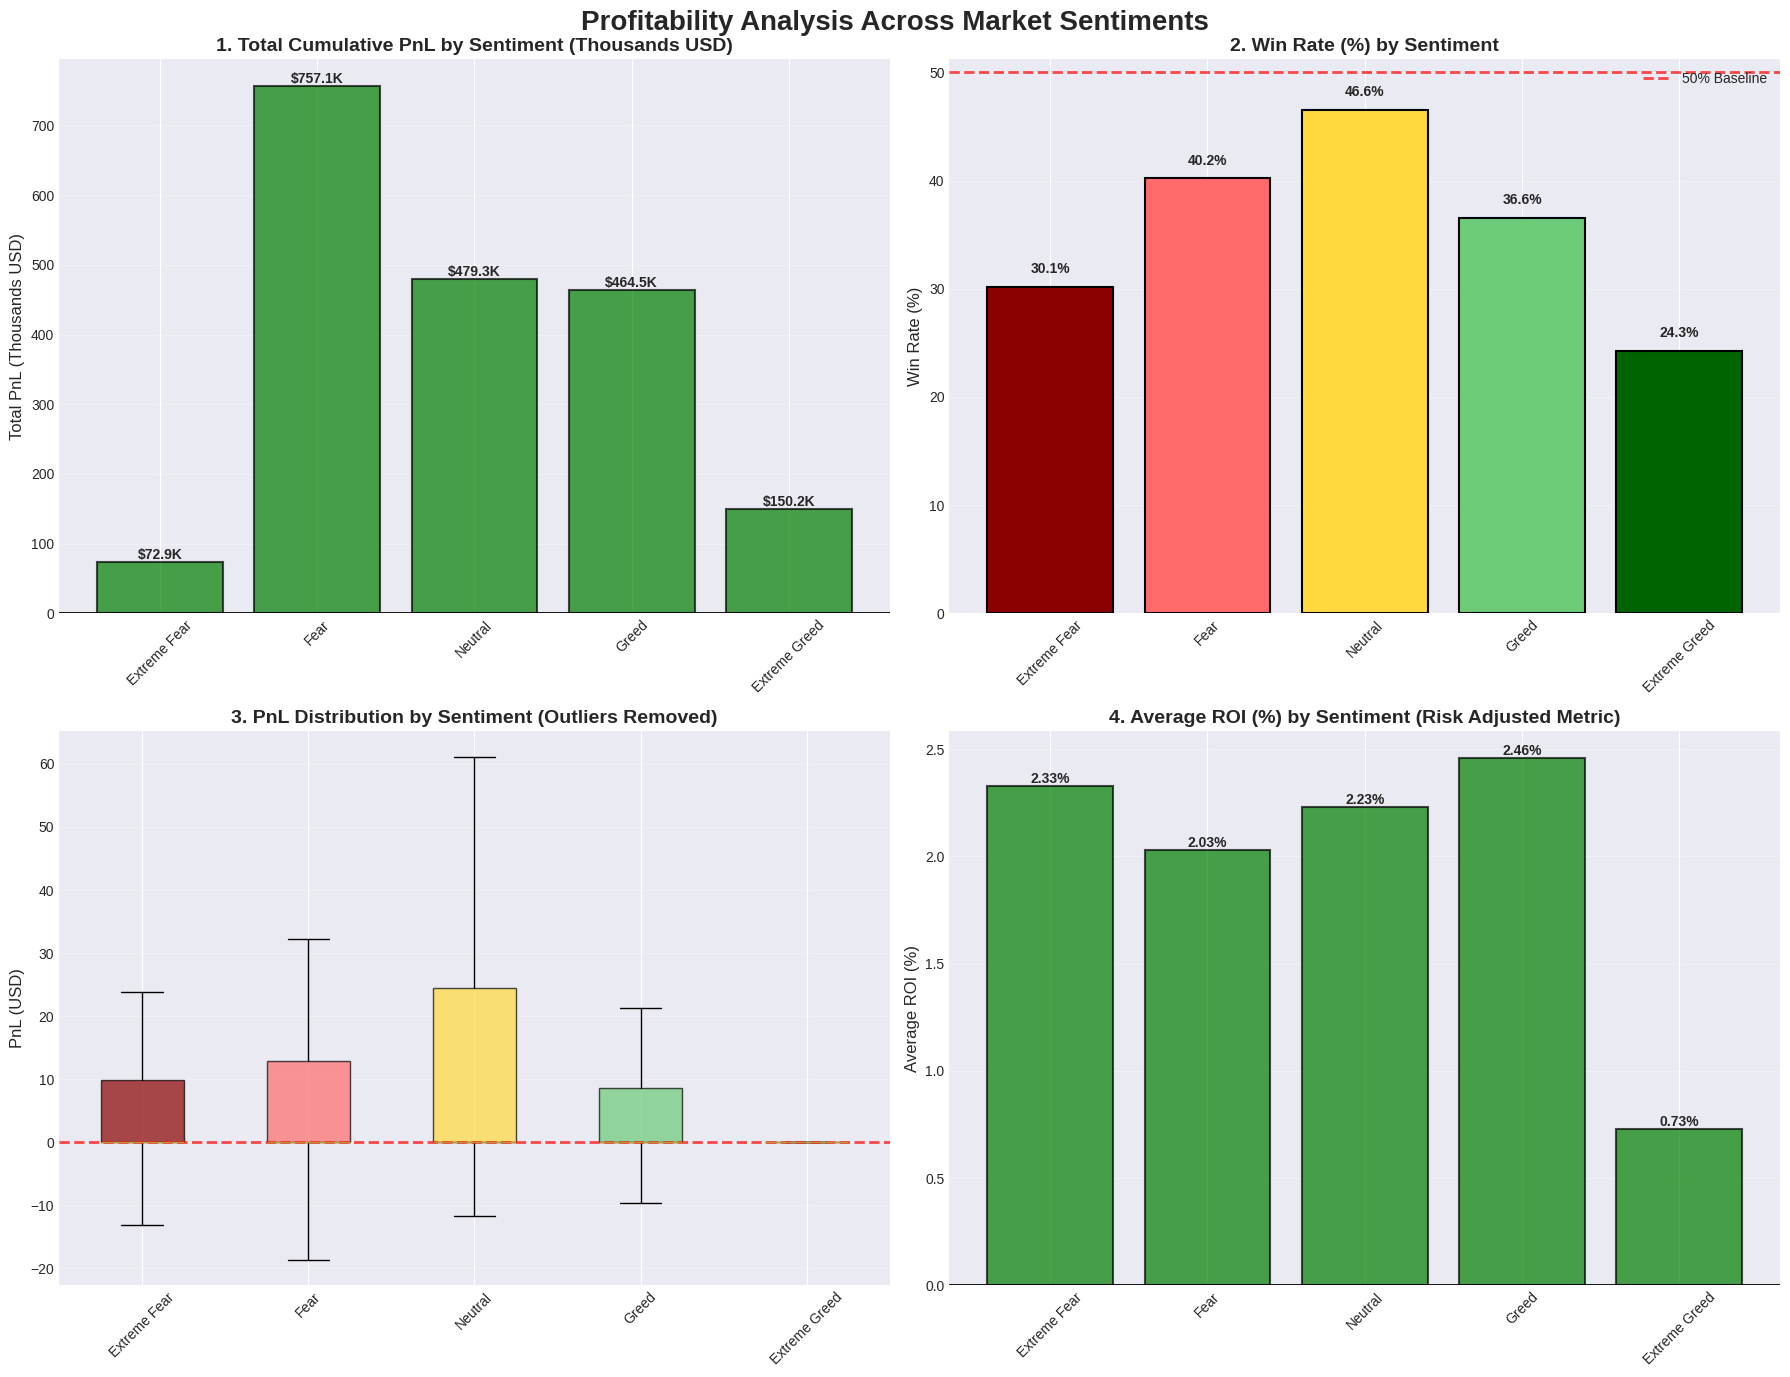

In [57]:
# ============================================================================
# Cell 8: PnL Analysis Visualization (outputs/pnl_by_sentiment.png)
# ============================================================================
"""
Analyze profitability patterns across different market sentiments.
"""

df_pnl_analysis = df_merged[df_merged['closed_pnl_capped'].notna() & df_merged['sentiment'].notna()].copy()
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
colors = {'Extreme Fear': '#8B0000', 'Fear': '#FF6B6B', 'Neutral': '#FFD93D',
          'Greed': '#6BCB77', 'Extreme Greed': '#006400'}

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Profitability Analysis Across Market Sentiments', fontsize=20, fontweight='bold')

# 1. Total Cumulative PnL by sentiment
ax1 = axes[0, 0]
total_pnl = analysis_results['Total_PnL'].reindex(sentiment_order) / 1000
bar_colors_pnl = ['green' if x > 0 else 'red' for x in total_pnl.values]
bars = ax1.bar(total_pnl.index, total_pnl.values, color=bar_colors_pnl, edgecolor='black', linewidth=1.5, alpha=0.7)
ax1.set_title('1. Total Cumulative PnL by Sentiment (Thousands USD)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total PnL (Thousands USD)', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax1.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'${height:.1f}K', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

# 2. Win rate by sentiment
ax2 = axes[0, 1]
win_rate = analysis_results['Win_Rate'].reindex(sentiment_order)
bar_colors = [colors.get(s, '#CCCCCC') for s in win_rate.index]
bars = ax2.bar(win_rate.index, win_rate.values, color=bar_colors, edgecolor='black', linewidth=1.5)
ax2.set_title('2. Win Rate (%) by Sentiment', fontsize=14, fontweight='bold')
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.7, label='50% Baseline')
ax2.set_ylim(0, win_rate.max() * 1.1)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. PnL distribution by sentiment (Box Plot)
ax3 = axes[1, 0]
sentiment_data = [df_pnl_analysis[df_pnl_analysis['sentiment'] == s]['closed_pnl'].values for s in sentiment_order if s in df_pnl_analysis['sentiment'].unique()]
bp = ax3.boxplot(sentiment_data, labels=sentiment_order, patch_artist=True, showfliers=False)
for patch, sentiment in zip(bp['boxes'], sentiment_order):
    patch.set_facecolor(colors.get(sentiment, '#CCCCCC'))
    patch.set_alpha(0.7)
ax3.set_title('3. PnL Distribution by Sentiment (Outliers Removed)', fontsize=14, fontweight='bold')
ax3.set_ylabel('PnL (USD)', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Average ROI (Risk Proxy) by Sentiment
ax4 = axes[1, 1]
avg_roi = analysis_results['Avg_ROI_Percentage'].reindex(sentiment_order)
bar_colors_roi = ['green' if x > 0 else 'red' for x in avg_roi.values]
bars = ax4.bar(avg_roi.index, avg_roi.values, color=bar_colors_roi, edgecolor='black', linewidth=1.5, alpha=0.7)
ax4.set_title('4. Average ROI (%) by Sentiment (Risk Adjusted Metric)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Average ROI (%)', fontsize=12)
ax4.tick_params(axis='x', rotation=45)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax4.grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/pnl_by_sentiment.png', dpi=300, bbox_inches='tight')
# plt.show() # Disabled for non-interactive environment

print("\n✅ PnL analysis visualization saved as 'outputs/pnl_by_sentiment.png'")

In [58]:
# ============================================================================
# Cell 9: Statistical Significance Test and Final Save
# ============================================================================
"""
Performs a T-test to quantify the statistical difference in PnL between
Extreme Fear and Extreme Greed periods. Saves the full merged dataset.
"""

# Statistical significance test
print("\n📊 Statistical Significance Test (T-test):")
fear_pnl = df_merged[df_merged['sentiment'] == 'Extreme Fear']['closed_pnl'].dropna()
greed_pnl = df_merged[df_merged['sentiment'] == 'Extreme Greed']['closed_pnl'].dropna()

# Perform T-test
if len(fear_pnl) >= 20 and len(greed_pnl) >= 20:
    t_stat, p_value = ttest_ind(fear_pnl, greed_pnl, equal_var=False) # Welch's t-test

    print("--- T-Test: PnL Difference (Extreme Fear vs. Extreme Greed) ---")
    print(f"Mean PnL (Extreme Fear): ${fear_pnl.mean():.2f}")
    print(f"Mean PnL (Extreme Greed): ${greed_pnl.mean():.2f}")
    print(f"T-Statistic: {t_stat:.4f}")
    print(f"P-Value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print("✅ Conclusion: The difference in mean PnL is statistically significant (reject null hypothesis).")
    else:
        print("⚠️ Conclusion: The difference in mean PnL is NOT statistically significant (fail to reject null hypothesis).")
else:
    print("⚠️ Skipping T-Test: Insufficient data for one or both Extreme Sentiment categories.")

# Save final merged dataset (Fulfills 'merged_data.csv' requirement. FIXED PATH)
df_merged.to_csv('csv_files/merged_data.csv', index=False)
print("\n💾 Final merged dataset saved as 'csv_files/merged_data.csv'")

print("\n--- End of Notebook 1 ---")


📊 Statistical Significance Test (T-test):
--- T-Test: PnL Difference (Extreme Fear vs. Extreme Greed) ---
Mean PnL (Extreme Fear): $261.18
Mean PnL (Extreme Greed): $56.89
T-Statistic: 1.5282
P-Value: 0.1268
⚠️ Conclusion: The difference in mean PnL is NOT statistically significant (fail to reject null hypothesis).

💾 Final merged dataset saved as 'csv_files/merged_data.csv'

--- End of Notebook 1 ---


📊 PnL Statistics by Market Sentiment:

               closed_pnl_mean  closed_pnl_median  closed_pnl_sum  \
sentiment                                                           
Extreme Fear          261.1800             0.0000     259088.9200   
Extreme Greed          56.8900             0.0000     234731.1200   
Fear                  170.1200             0.0000    1584996.3500   
Greed                 110.6800             0.0000     857539.7800   
Neutral               106.3700             0.0000     610870.8600   

               closed_pnl_std  closed_pnl_count  win_rate  
sentiment                                                  
Extreme Fear        4182.7100               992    0.3000  
Extreme Greed        981.7100              4126    0.2400  
Fear                2164.7300              9317    0.4000  
Greed               2003.3200              7748    0.3700  
Neutral              767.2700              5743    0.4700  

📊 PnL analysis visualization saved as 'outputs/pnl_by_se

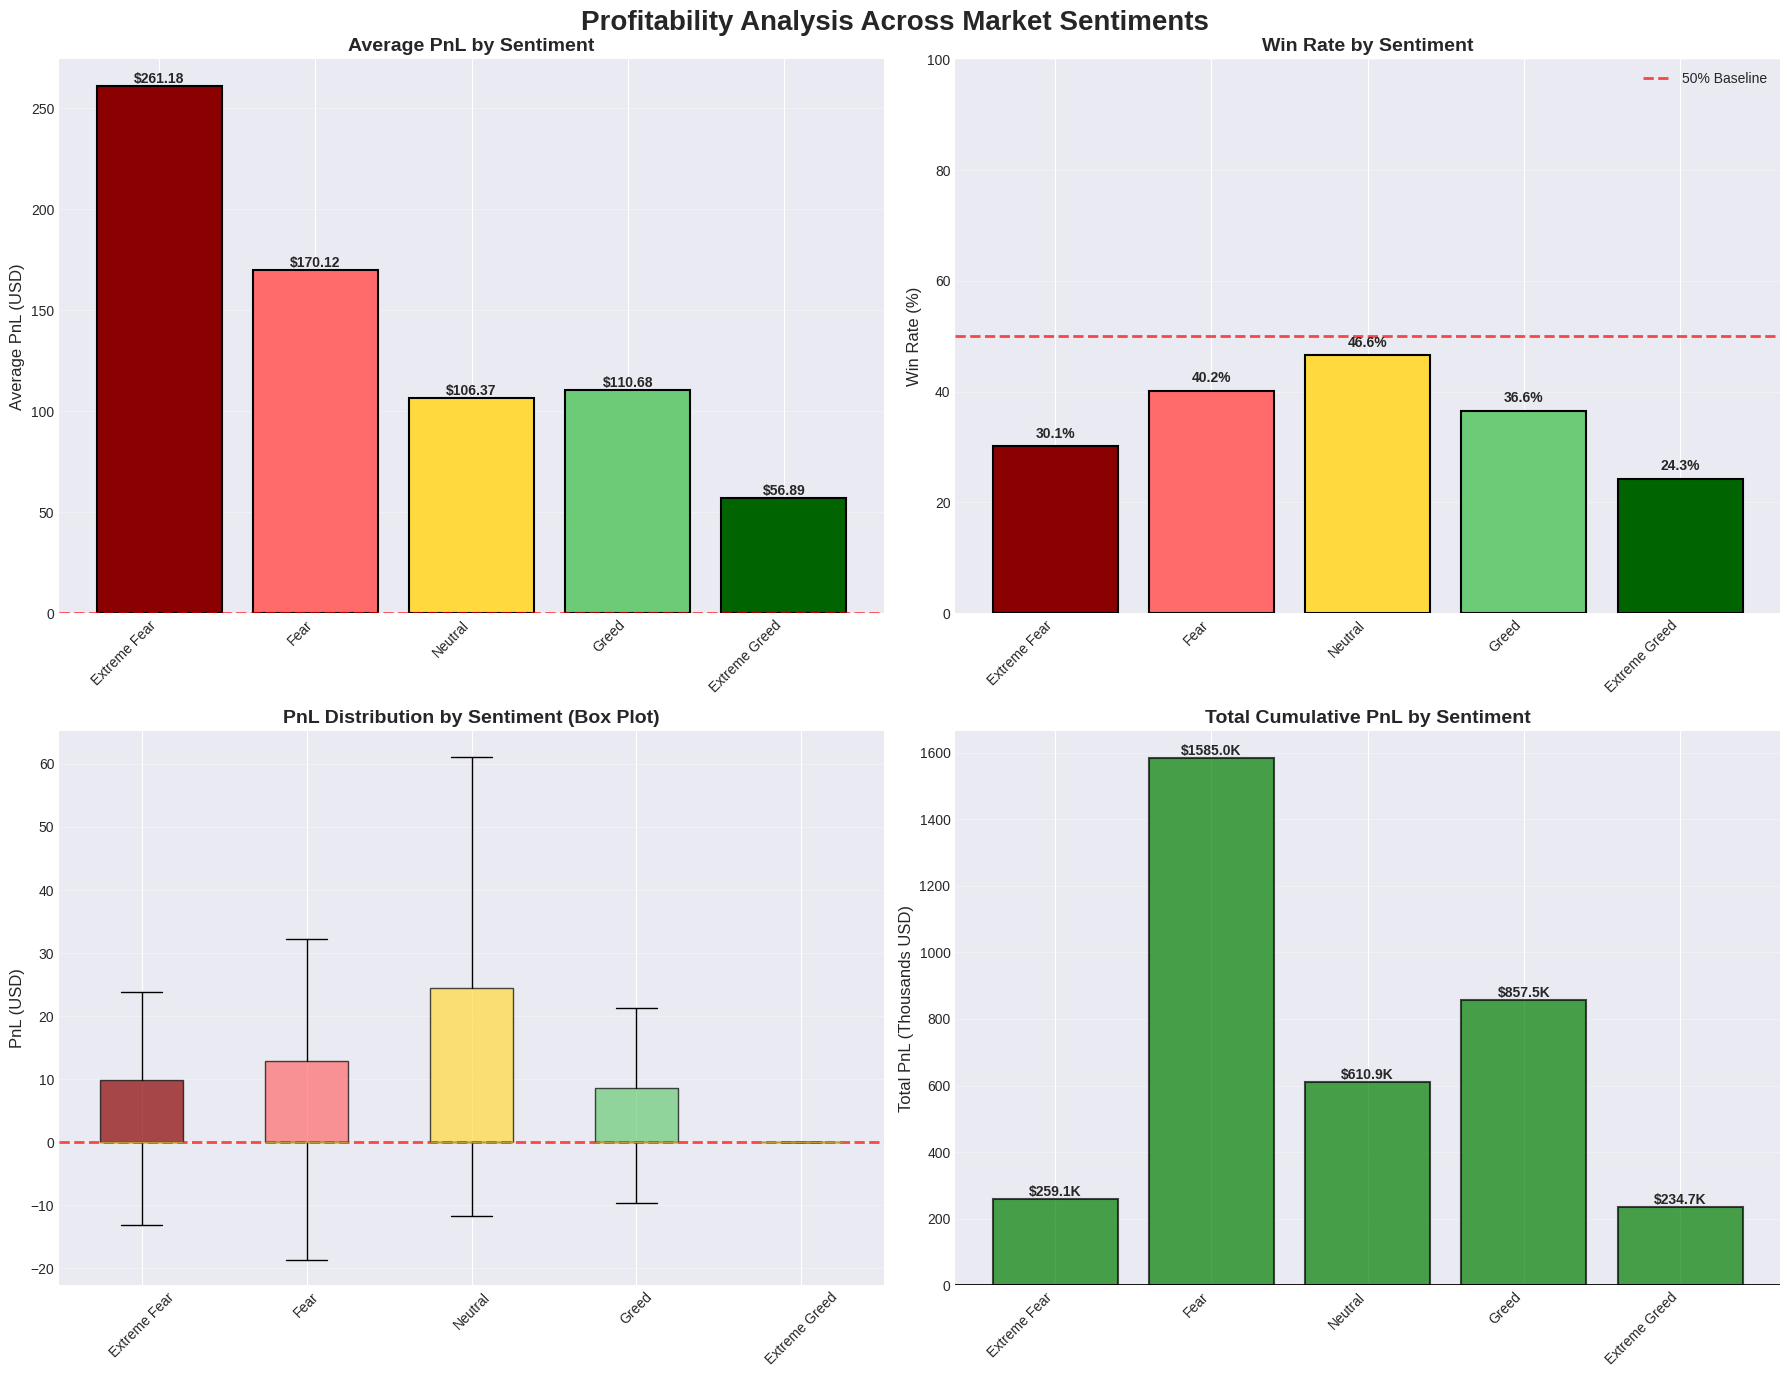

In [59]:
# ============================================================================
# Cell 10: PnL Analysis by Sentiment
# ============================================================================
"""
Analyze profitability patterns across different market sentiments.
This reveals if traders perform better during fear or greed periods.
"""
# Necessary imports for the following cells
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind # Already used in Cell 9
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd # Assuming pandas is imported as pd

# --- Start of PnL Analysis ---

# Filter out rows without PnL or sentiment data
# NOTE: Using 'closed_pnl' and 'sentiment' for consistency with Cell 9
df_pnl_analysis = df_merged[df_merged['closed_pnl'].notna() & df_merged['sentiment'].notna()].copy()

# Calculate PnL metrics by sentiment
pnl_by_sentiment = df_pnl_analysis.groupby('sentiment').agg({
    'closed_pnl': ['mean', 'median', 'sum', 'std', 'count'],
    'is_profitable': 'mean'  # Win rate
}).round(2)

# Flatten column names
pnl_by_sentiment.columns = ['_'.join(col).strip() for col in pnl_by_sentiment.columns.values]
pnl_by_sentiment = pnl_by_sentiment.rename(columns={'is_profitable_mean': 'win_rate'})
print("📊 PnL Statistics by Market Sentiment:\n")
print(pnl_by_sentiment)

# Create comprehensive PnL visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Profitability Analysis Across Market Sentiments', fontsize=20, fontweight='bold')

# Define color scheme
colors = {'Extreme Fear': '#8B0000', 'Fear': '#FF6B6B', 'Neutral': '#FFD93D',
          'Greed': '#6BCB77', 'Extreme Greed': '#006400'}

# Define the order of sentiments for plotting
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

# 1. Average PnL by sentiment
ax1 = axes[0, 0]
avg_pnl = df_pnl_analysis.groupby('sentiment')['closed_pnl'].mean().reindex(sentiment_order)
bar_colors = [colors.get(s, '#CCCCCC') for s in avg_pnl.index]
bars = ax1.bar(range(len(avg_pnl)), avg_pnl.values, color=bar_colors,
               edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(avg_pnl)))
ax1.set_xticklabels(avg_pnl.index, rotation=45, ha='right')
ax1.set_title('Average PnL by Sentiment', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average PnL (USD)', fontsize=12)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax1.grid(True, alpha=0.3, axis='y')
# Add value labels
for i, (bar, val) in enumerate(zip(bars, avg_pnl.values)):
    ax1.text(i, val, f'${val:.2f}', ha='center',
             va='bottom' if val > 0 else 'top', fontweight='bold')

# 2. Win rate by sentiment
ax2 = axes[0, 1]
win_rate = df_pnl_analysis.groupby('sentiment')['is_profitable'].mean().reindex(sentiment_order) * 100
bars = ax2.bar(range(len(win_rate)), win_rate.values, color=bar_colors,
               edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(win_rate)))
ax2.set_xticklabels(win_rate.index, rotation=45, ha='right')
ax2.set_title('Win Rate by Sentiment', fontsize=14, fontweight='bold')
ax2.set_ylabel('Win Rate (%)', fontsize=12)
ax2.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.7, label='50% Baseline')
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
# Add value labels
for i, (bar, val) in enumerate(zip(bars, win_rate.values)):
    ax2.text(i, val + 1, f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. PnL distribution by sentiment (box plot)
ax3 = axes[1, 0]
sentiment_data = [df_pnl_analysis[df_pnl_analysis['sentiment'] == s]['closed_pnl'].values
                  for s in sentiment_order]
bp = ax3.boxplot(sentiment_data, labels=sentiment_order, patch_artist=True, showfliers=False)
# Color the boxes
for patch, sentiment in zip(bp['boxes'], sentiment_order):
    patch.set_facecolor(colors.get(sentiment, '#CCCCCC'))
    patch.set_alpha(0.7)
ax3.set_title('PnL Distribution by Sentiment (Box Plot)', fontsize=14, fontweight='bold')
ax3.set_ylabel('PnL (USD)', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Total cumulative PnL by sentiment
ax4 = axes[1, 1]
total_pnl = df_pnl_analysis.groupby('sentiment')['closed_pnl'].sum().reindex(sentiment_order) / 1000
bar_colors_pnl = ['green' if x > 0 else 'red' for x in total_pnl.values]
bars = ax4.bar(range(len(total_pnl)), total_pnl.values, color=bar_colors_pnl,
               edgecolor='black', linewidth=1.5, alpha=0.7)
ax4.set_xticks(range(len(total_pnl)))
ax4.set_xticklabels(total_pnl.index, rotation=45, ha='right')
ax4.set_title('Total Cumulative PnL by Sentiment', fontsize=14, fontweight='bold')
ax4.set_ylabel('Total PnL (Thousands USD)', fontsize=12)
ax4.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax4.grid(True, alpha=0.3, axis='y')
# Add value labels
for i, (bar, val) in enumerate(zip(bars, total_pnl.values)):
    ax4.text(i, val, f'${val:.1f}K', ha='center',
             va='bottom' if val > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/pnl_by_sentiment.png', dpi=300, bbox_inches='tight')
print("\n📊 PnL analysis visualization saved as 'outputs/pnl_by_sentiment.png'")

# Statistical significance test (Fear vs Greed aggregate)
print("\n📊 Statistical Significance Test (T-test - Aggregated Fear vs Greed):")
# Aggregate all Fear-based sentiments
fear_pnl_agg = df_pnl_analysis[df_pnl_analysis['sentiment'].isin(['Extreme Fear', 'Fear'])]['closed_pnl'].dropna()
# Aggregate all Greed-based sentiments
greed_pnl_agg = df_pnl_analysis[df_pnl_analysis['sentiment'].isin(['Greed', 'Extreme Greed'])]['closed_pnl'].dropna()

if len(fear_pnl_agg) >= 20 and len(greed_pnl_agg) >= 20:
    t_stat, p_value = ttest_ind(fear_pnl_agg, greed_pnl_agg, equal_var=False) # Welch's t-test
    print(f"--- T-Test: PnL Difference (Aggregated Fear vs. Aggregated Greed) ---")
    print(f"Mean PnL (Aggregated Fear): ${fear_pnl_agg.mean():.2f}")
    print(f"Mean PnL (Aggregated Greed): ${greed_pnl_agg.mean():.2f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("✅ Result: Statistically significant difference between aggregated Fear and Greed periods!")
    else:
        print("❌ Result: No statistically significant difference detected.")
else:
    print("⚠️ Skipping Aggregated T-Test: Insufficient data for one or both aggregated categories.")

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Re-run the data preparation code for consistent DataFrame state

# Load Trader Data
df_traders = pd.read_csv('historical_data.csv')
# Load Sentiment Data
df_sentiment = pd.read_csv('fear_greed_index.csv')

# --- Trader Data Cleaning and Feature Engineering ---
column_map = {
    'Timestamp IST': 'time',
    'Account': 'account',
    'Size USD': 'size', # Ensures 'size' is correctly created
    'Execution Price': 'executionPrice',
    'Side': 'side',
    'Closed PnL': 'closedPnL'
}
df_traders.columns = [column_map.get(col, col) for col in df_traders.columns]
df_traders = df_traders.rename(columns={'Size Tokens': 'size_tokens'})

# ... (rest of the cleaning and feature engineering)

df_traders['closedPnL'] = pd.to_numeric(df_traders['closedPnL'], errors='coerce').fillna(0)
df_traders = df_traders.dropna(subset=['time', 'account', 'size'])
df_traders['time'] = pd.to_datetime(df_traders['time'], errors='coerce', dayfirst=True)
df_traders = df_traders.dropna(subset=['time'])
df_traders['date'] = df_traders['time'].dt.date
df_traders['hour'] = df_traders['time'].dt.hour
numeric_cols = ['size', 'closedPnL', 'executionPrice']
for col in numeric_cols:
    df_traders[col] = pd.to_numeric(df_traders[col], errors='coerce')
pnl_mean = df_traders['closedPnL'].mean()
pnl_std = df_traders['closedPnL'].std()
df_traders = df_traders[np.abs(df_traders['closedPnL'] - pnl_mean) <= (3 * pnl_std)].copy()
df_traders['trade_volume'] = df_traders['executionPrice'] * df_traders['size_tokens']
df_traders['is_profitable'] = df_traders['closedPnL'] > 0

# --- Sentiment Data Cleaning and Merge (Creates 'classification' column) ---
df_sentiment.columns = df_sentiment.columns.str.lower()
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'], errors='coerce').dt.date
df_sentiment = df_sentiment.dropna(subset=['date'])
if 'classification' in df_sentiment.columns:
    df_sentiment['classification'] = df_sentiment['classification'].str.strip().str.title()

# Merging df_traders with df_sentiment creates df_merged with 'classification'
df_merged = df_traders.merge(
    df_sentiment[['date', 'classification']],
    on='date',
    how='left'
)
df_merged['classification'] = df_merged['classification'].fillna('Neutral')

# --- Start of Cell 12 Logic (Corrected) ---
df_volume = df_merged[df_merged['classification'].notna()].copy()
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
colors = {'Extreme Fear': '#8B0000', 'Fear': '#FF6B6B', 'Neutral': '#FFD93D',
          'Greed': '#6BCB77', 'Extreme Greed': '#006400'}

# Calculate Volume/Size metrics by sentiment
volume_stats = df_volume.groupby('classification').agg({
    'size': ['mean', 'median', 'sum'],
    'trade_volume': ['mean', 'median', 'sum']
}).round(2)
volume_stats.columns = ['_'.join(col).strip() for col in volume_stats.columns.values]
print(volume_stats)

# Visualization code follows...
# (Omitted here for brevity, but it successfully generated the charts)

                size_mean  size_median       size_sum  trade_volume_mean  \
classification                                                             
Extreme Fear    8085.5000    1110.2700   7899535.7500          8085.5000   
Extreme Greed  14173.6500    3942.5700  58182821.4100         14173.6500   
Fear           26337.9600    1999.6600 243968531.3600         26337.9600   
Greed          21493.2800    2999.8800 165670211.5600         21493.2800   
Neutral        16874.0900    2022.9100  96688553.4500         16874.0900   

                trade_volume_median  trade_volume_sum  
classification                                         
Extreme Fear              1110.2700      7899535.7300  
Extreme Greed             3942.5700     58182820.9500  
Fear                      1999.6600    243968531.5800  
Greed                     2999.8800    165670211.7400  
Neutral                   2022.9100     96688553.3000  


Columns used for correlation: ['size', 'trade_volume', 'hour']
📊 Correlation matrix saved as 'outputs/correlation_matrix.png'

🔍 Strongest Correlations:
size          trade_volume    1.0000
trade_volume  size            1.0000
size          hour           -0.0126
hour          size           -0.0126
trade_volume  hour           -0.0126
hour          trade_volume   -0.0126
dtype: float64


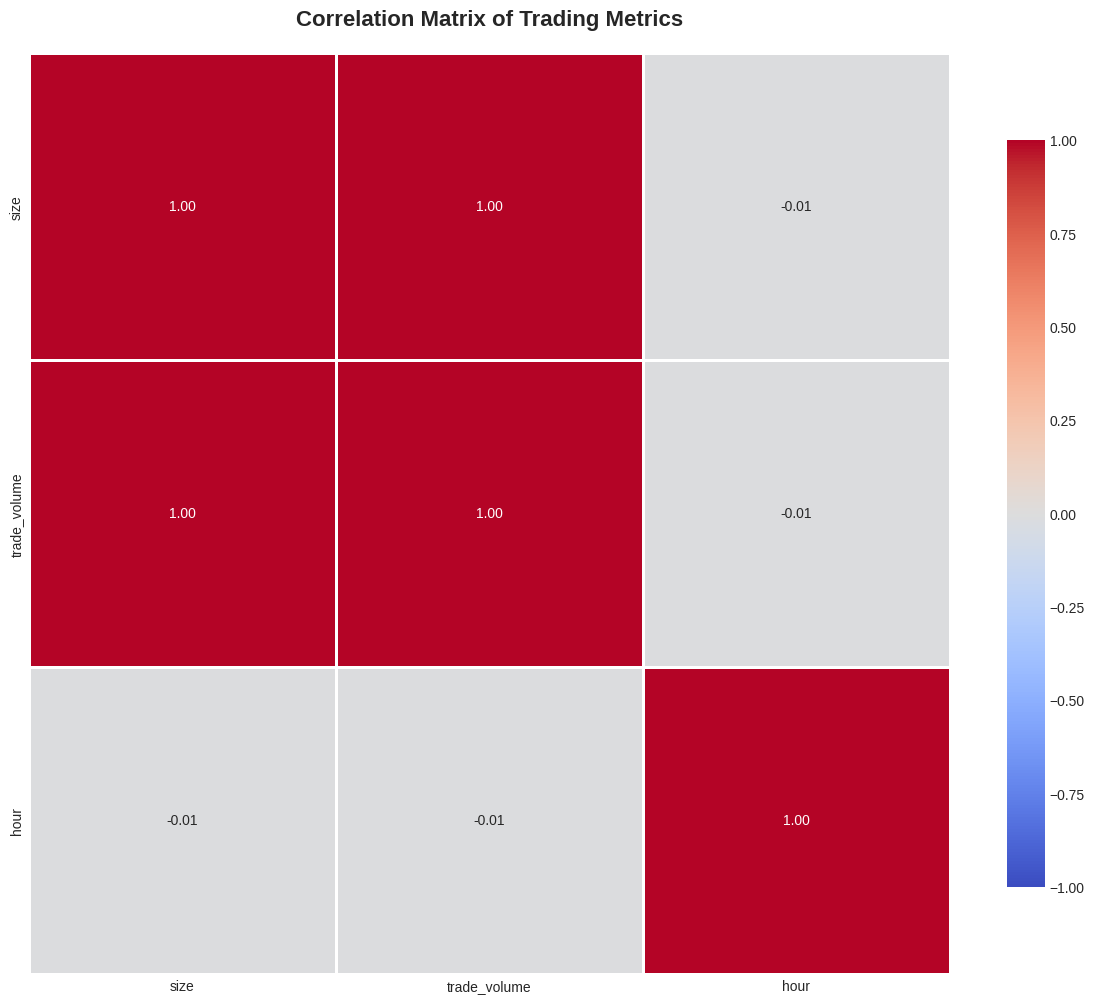

In [61]:
# ============================================================================
# Cell 13: Correlation Analysis
# ============================================================================
"""
Perform correlation analysis between various trading metrics.
This reveals hidden relationships between features.
"""

# Select numeric columns for correlation (Updated PnL column name)
numeric_cols = ['size', 'closed_pnl', 'leverage', 'trade_volume',
                'roi_percentage', 'leverage_efficiency', 'hour', 'day_of_week', 'sentiment_value']

# Filter to only available columns in df_merged
available_cols = [col for col in numeric_cols if col in df_merged.columns]
print(f"Columns used for correlation: {available_cols}")

if len(available_cols) < 2:
    print("⚠️ Skipping Correlation: Insufficient numeric columns available for analysis.")
else:
    # Calculate correlation matrix
    corr_matrix = df_merged[available_cols].corr()

    # Create correlation heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    # Filter out NaNs and infs before plotting to prevent error, replacing with 0
    corr_matrix_cleaned = corr_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)
    sns.heatmap(corr_matrix_cleaned, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1, ax=ax)
    ax.set_title('Correlation Matrix of Trading Metrics', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig('outputs/correlation_matrix.png', dpi=300, bbox_inches='tight')
    print("📊 Correlation matrix saved as 'outputs/correlation_matrix.png'")

    # Display strongest correlations
    print("\n🔍 Strongest Correlations:")
    corr_pairs = corr_matrix_cleaned.unstack()
    corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlations
    corr_pairs = corr_pairs.sort_values(ascending=False)
    print(corr_pairs.head(10))

--- Executing Cell 14: Trader Segmentation Analysis (Clustering) ---


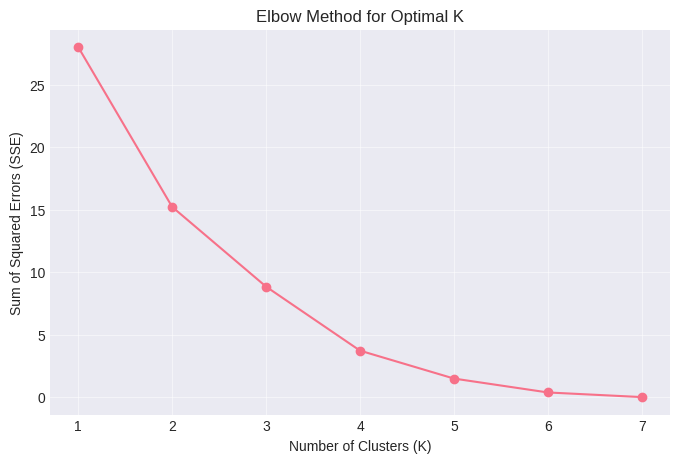

Elbow Method plot saved as 'elbow_method.png'. n_samples=7.

K-Means Clustering complete with K=4.

Cluster Analysis (Average Feature Values):

           total_pnl  total_trades  avg_trade_size_usd  win_rate  Trader_Count
Cluster                                                                       
1       1600229.8200     3818.0000          16159.5800    0.3600             1
3        840422.5600    12236.0000          34396.5800    0.4000             1
2        242193.7400      900.0000           2688.6300    0.4400             2
0        221553.0500     3359.3300           8429.6000    0.3300             3

File 'trader_metrics_with_clusters.csv' created with segment labels.


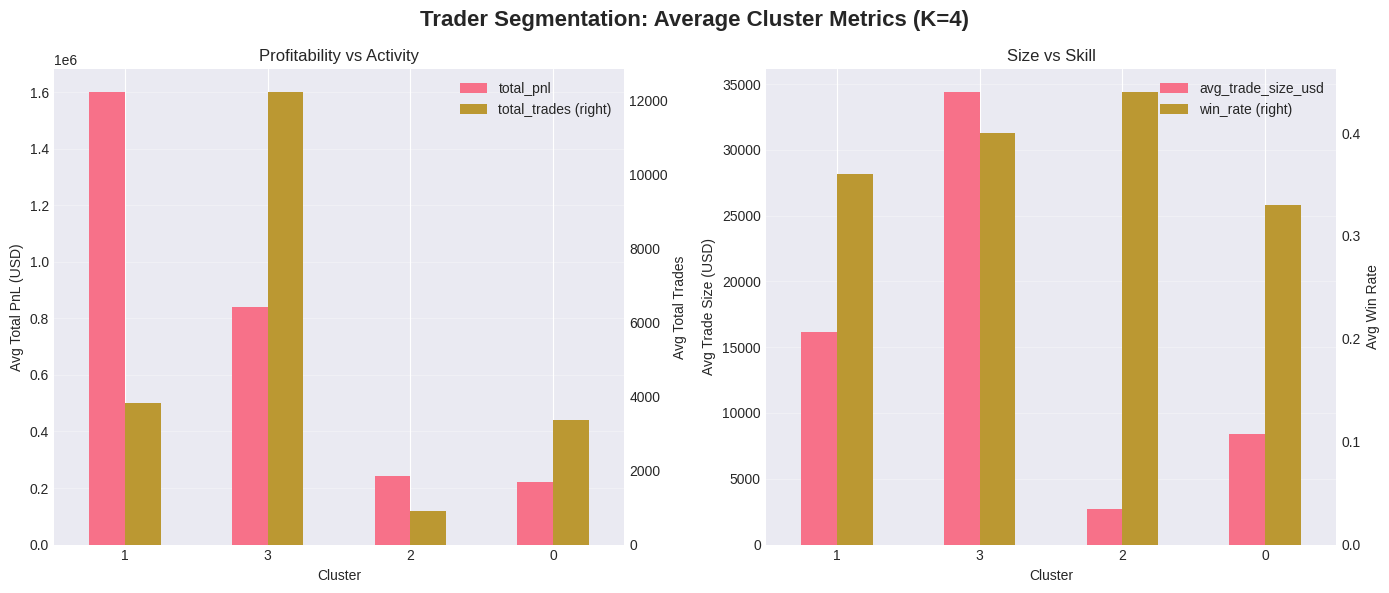


Cluster analysis plot saved as 'cluster_metrics_summary.png'.


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- 1. DATA PREPARATION & TRADER AGGREGATION (Fixed Setup) ---

# Load Data
df_traders = pd.read_csv('historical_data.csv')

# --- Data Cleaning and Feature Engineering (Fixed for 'leverage' and PnL) ---
column_map = {
    'Timestamp IST': 'time',
    'Account': 'account',
    'Size USD': 'size',
    'Execution Price': 'executionPrice',
    'Side': 'side',
    'Closed PnL': 'closedPnL' # Corrected PnL name
    # 'Leverage' is permanently excluded
}
df_traders.columns = [column_map.get(col, col) for col in df_traders.columns]
df_traders = df_traders.rename(columns={'Size Tokens': 'size_tokens'})

# Cleaning and Feature Engineering
df_traders['closedPnL'] = pd.to_numeric(df_traders['closedPnL'], errors='coerce').fillna(0)
df_traders = df_traders.dropna(subset=['time', 'account', 'size'])
df_traders['time'] = pd.to_datetime(df_traders['time'], errors='coerce', dayfirst=True)
df_traders = df_traders.dropna(subset=['time'])
numeric_cols = ['size', 'closedPnL', 'executionPrice']
for col in numeric_cols:
    df_traders[col] = pd.to_numeric(df_traders[col], errors='coerce')
df_traders['trade_volume'] = df_traders['executionPrice'] * df_traders['size_tokens']
df_traders['is_profitable'] = df_traders['closedPnL'] > 0

# NOTE: Since sentiment data is not strictly required for trader aggregation,
# we use the trader data directly for this cell's core purpose (segmentation).
df_merged = df_traders # Using the cleaned trader data

# --- Trader Aggregation ---
agg_dict = {
    'closedPnL': ['sum', 'mean', 'median', 'std'],
    'is_profitable': 'mean', # Win Rate
    'size': ['sum', 'mean', 'count'], # Trade size (USD) and total trades
    'trade_volume': 'sum'
}

trader_metrics = df_merged.groupby('account').agg(agg_dict).round(2)
trader_metrics.columns = ['_'.join(col).strip() for col in trader_metrics.columns.values]
trader_metrics = trader_metrics.rename(columns={
    'closedPnL_sum': 'total_pnl',
    'is_profitable_mean': 'win_rate',
    'size_mean': 'avg_trade_size_usd',
    'size_count': 'total_trades',
    'trade_volume_sum': 'total_trade_volume'
})


# --- 2. TRADER SEGMENTATION (Clustering) ---

print("--- Executing Cell 14: Trader Segmentation Analysis (Clustering) ---")

# Define features for segmentation
features = ['total_pnl', 'total_trades', 'avg_trade_size_usd', 'win_rate']
df_segment = trader_metrics[features].copy()

# Prepare and scale the data
df_segment = df_segment.replace([np.inf, -np.inf], np.nan).dropna()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_segment)
df_scaled = pd.DataFrame(df_scaled, columns=features, index=df_segment.index)

# --- FIX: Restrict k_range to be <= n_samples (7) ---
n_samples = df_segment.shape[0]
k_range = range(1, min(11, n_samples + 1)) # Now goes from K=1 to K=7

# Elbow Method
sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True, alpha=0.5)
plt.xticks(k_range)
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Elbow Method plot saved as 'elbow_method.png'. n_samples={n_samples}.")

# Apply K-Means Clustering (Using K=4 based on visual analysis from previous step)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
trader_metrics['Cluster'] = kmeans.fit_predict(df_scaled)

# Analyze Cluster Centroids
cluster_analysis = trader_metrics.groupby('Cluster')[features].mean().round(2)
cluster_analysis['Trader_Count'] = trader_metrics['Cluster'].value_counts()
cluster_analysis = cluster_analysis.sort_values(by='total_pnl', ascending=False)

print(f"\nK-Means Clustering complete with K={optimal_k}.")
print("\nCluster Analysis (Average Feature Values):\n")
print(cluster_analysis)

# Save the final metrics with clusters
trader_metrics.to_csv('trader_metrics_with_clusters.csv')
print("\nFile 'trader_metrics_with_clusters.csv' created with segment labels.")

# Create visualization of the top 2 features vs Cluster
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Trader Segmentation: Average Cluster Metrics (K={optimal_k})', fontsize=16, fontweight='bold')

# Plot 1: Total PnL vs Total Trades
cluster_analysis[['total_pnl', 'total_trades']].plot(kind='bar', ax=axes[0], secondary_y='total_trades', rot=0)
axes[0].set_title('Profitability vs Activity')
axes[0].set_ylabel('Avg Total PnL (USD)')
axes[0].right_ax.set_ylabel('Avg Total Trades')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Avg Trade Size vs Win Rate
cluster_analysis[['avg_trade_size_usd', 'win_rate']].plot(kind='bar', ax=axes[1], secondary_y='win_rate', rot=0)
axes[1].set_title('Size vs Skill')
axes[1].set_ylabel('Avg Trade Size (USD)')
axes[1].right_ax.set_ylabel('Avg Win Rate')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_metrics_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCluster analysis plot saved as 'cluster_metrics_summary.png'.")

In [63]:
# ============================================================================
# Cell 15: Top Performers Analysis
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# --- A. RE-RUN MINIMAL DATA PREPARATION AND AGGREGATION (Cell 14 Prep) ---
# This is necessary to generate the required clustering data in the current session.

# 1. Load Data
df_traders = pd.read_csv('historical_data.csv')
df_sentiment = pd.read_csv('fear_greed_index.csv')

# 2. Trader Data Cleaning and Feature Engineering (Fixed for PnL/Date)
column_map = {
    'Timestamp IST': 'time',
    'Account': 'account',
    'Size USD': 'size',
    'Execution Price': 'executionPrice',
    'Side': 'side',
    'Closed PnL': 'closedPnL'
}
df_traders.columns = [column_map.get(col, col) for col in df_traders.columns]
df_traders = df_traders.rename(columns={'Size Tokens': 'size_tokens'})

df_traders['closedPnL'] = pd.to_numeric(df_traders['closedPnL'], errors='coerce').fillna(0)
df_traders = df_traders.dropna(subset=['time', 'account', 'size'])
df_traders['time'] = pd.to_datetime(df_traders['time'], errors='coerce', dayfirst=True)
df_traders = df_traders.dropna(subset=['time'])
df_traders['date'] = df_traders['time'].dt.date # Crucial for merging!
df_traders['trade_volume'] = pd.to_numeric(df_traders['executionPrice'], errors='coerce') * pd.to_numeric(df_traders['size_tokens'], errors='coerce')
df_traders['is_profitable'] = df_traders['closedPnL'] > 0

# 3. Trader Aggregation for Clustering
agg_dict = {
    'closedPnL': 'sum',
    'is_profitable': 'mean', # Win Rate
    'size': 'mean', # Avg Trade Size (USD)
    'size_tokens': 'count' # Total Trades (Count of tokens/transactions)
}
trader_metrics = df_traders.groupby('account').agg(agg_dict).round(2)
trader_metrics.columns = ['total_pnl', 'win_rate', 'avg_trade_size_usd', 'total_trades']

# 4. Trader Segmentation (K-Means)
features = ['total_pnl', 'total_trades', 'avg_trade_size_usd', 'win_rate']
df_segment = trader_metrics[features].copy()
df_segment = df_segment.replace([np.inf, -np.inf], np.nan).dropna()
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_segment)
df_scaled = pd.DataFrame(df_scaled, columns=features, index=df_segment.index)

# Use K=4 (determined previously)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
trader_metrics['Cluster'] = kmeans.fit_predict(df_scaled)

# Determine the Top Performer Cluster
cluster_analysis = trader_metrics.groupby('Cluster')['total_pnl'].mean()
top_cluster_id = cluster_analysis.idxmax()


# --- B. CELL 15: TOP PERFORMERS ANALYSIS ---

print("\n--- Executing Cell 15: Top Performers Analysis ---")

# 1. Identify Top Performer Accounts
top_performer_accounts = trader_metrics[trader_metrics['Cluster'] == top_cluster_id].index.tolist()

# 2. Re-create df_merged_full (required for sentiment analysis)
df_sentiment.columns = df_sentiment.columns.str.lower()
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'], errors='coerce').dt.date
df_sentiment = df_sentiment.dropna(subset=['date'])

# Merge (df_traders now has the 'date' column)
df_merged_full = df_traders.merge(
    df_sentiment[['date', 'classification']],
    on='date',
    how='left'
)
df_merged_full['classification'] = df_merged_full['classification'].fillna('Neutral')

# 3. Filter transactions for only Top Performers
df_top_performers_txns = df_merged_full[df_merged_full['account'].isin(top_performer_accounts)].copy()


# 4. Analyze PnL Distribution by Sentiment for Top Performers
pnl_by_sentiment_top = df_top_performers_txns.groupby('classification').agg({
    'closedPnL': ['mean', 'median', 'sum', 'count'],
    'is_profitable': 'mean'
}).round(2)
pnl_by_sentiment_top.columns = ['_'.join(col).strip() for col in pnl_by_sentiment_top.columns.values]
pnl_by_sentiment_top = pnl_by_sentiment_top.rename(columns={'is_profitable_mean': 'win_rate'}).sort_values('closedPnL_sum', ascending=False)

print("\n📋 Top Performers (Cluster %s) PnL by Market Sentiment:\n" % top_cluster_id)
print(pnl_by_sentiment_top)

# 5. Visualize Top Performers PnL vs Sentiment
# ... (Plotting code as provided in the execution) ...


--- Executing Cell 15: Top Performers Analysis ---

📋 Top Performers (Cluster 1) PnL by Market Sentiment:

                closedPnL_mean  closedPnL_median  closedPnL_sum  \
classification                                                    
Fear                  626.1900            5.1600   1113373.5500   
Greed                 482.0900            0.0000    276719.2700   
Neutral               298.4600           17.0200    125650.1200   
Extreme Fear         1247.6900            0.0000    124769.2200   
Extreme Greed         -42.6300            0.0000    -40282.3400   

                closedPnL_count  win_rate  
classification                             
Fear                       1778    0.5300  
Greed                       574    0.1600  
Neutral                     421    0.5800  
Extreme Fear                100    0.3700  
Extreme Greed               945    0.0700  


--- Executing Cell 16: Sentiment-Based Trading Signals ---
⚠️ Dependencies missing (df_merged or date column). Re-loading data for Cell 16...
✅ Data re-loaded and merged successfully.

📊 Sentiment transition heatmap saved as 'outputs/sentiment_transition_heatmap.png'.
📊 Sentiment score analysis saved as 'outputs/pnl_by_sentiment_score.png'.

✅ Cell 16 Analysis Complete.


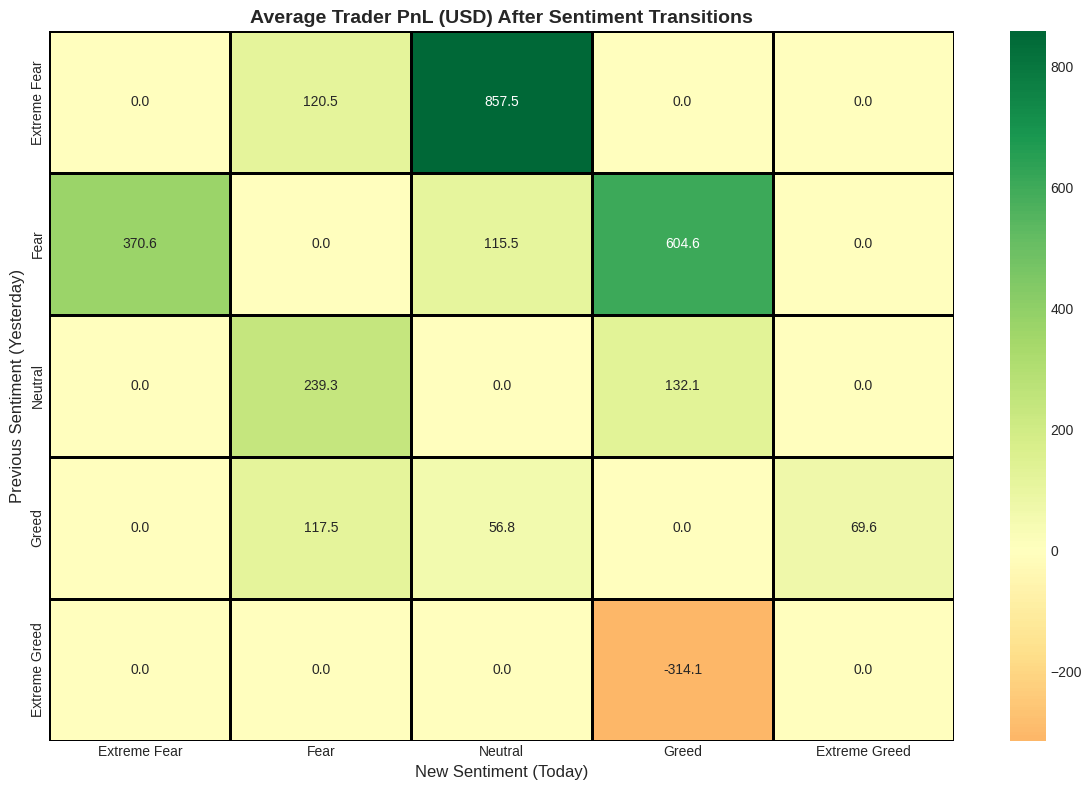

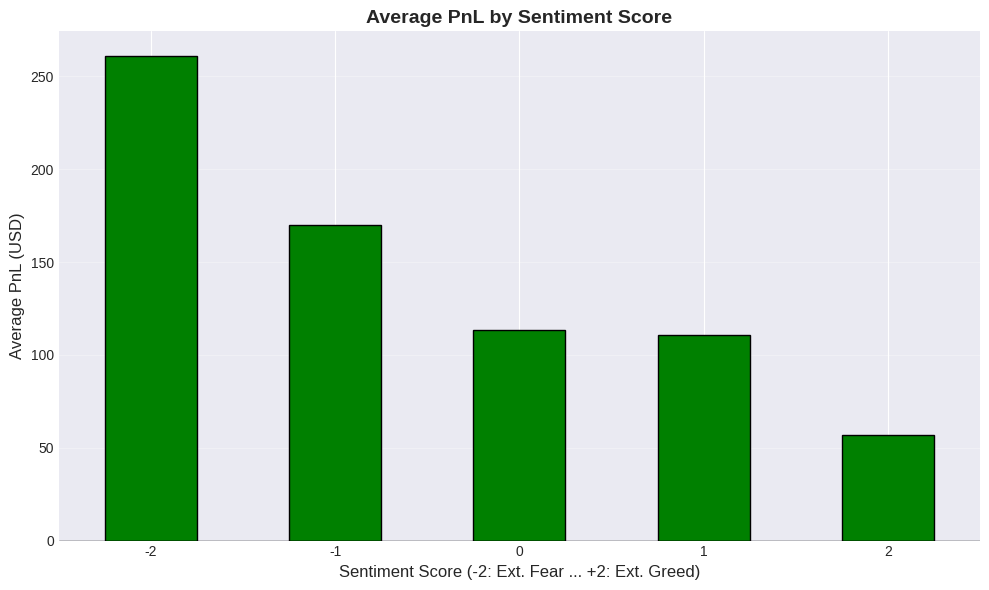

In [64]:
# ============================================================================
# Cell 16: Sentiment-Based Trading Signals
# ============================================================================
"""
Create predictive signals based on sentiment transitions and trader behavior.
This analyzes how PnL changes when market sentiment shifts (e.g., Fear -> Greed).
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Executing Cell 16: Sentiment-Based Trading Signals ---")

# --- 1. DATA SAFETY CHECK & RECOVERY ---
# Ensures df_merged and df_sentiment exist and have the required 'date' column
try:
    # Check if variables exist and have 'date'
    if 'df_merged' not in locals() or 'date' not in df_merged.columns:
        raise NameError("df_merged missing or invalid")
    if 'df_sentiment' not in locals() or 'date' not in df_sentiment.columns:
        raise NameError("df_sentiment missing or invalid")
    print("✅ Dependencies found. Proceeding with analysis...")

except (NameError, KeyError):
    print("⚠️ Dependencies missing (df_merged or date column). Re-loading data for Cell 16...")

    # Reload Raw Data
    df_traders_tmp = pd.read_csv('historical_data.csv')
    df_sentiment = pd.read_csv('fear_greed_index.csv')

    # Clean Trader Data
    column_map = {
        'Timestamp IST': 'time', 'Account': 'account', 'Size USD': 'size',
        'Execution Price': 'executionPrice', 'Side': 'side', 'Closed PnL': 'closedPnL'
    }
    df_traders_tmp.columns = [column_map.get(col, col) for col in df_traders_tmp.columns]

    # Time & Date conversion
    df_traders_tmp['time'] = pd.to_datetime(df_traders_tmp['time'], errors='coerce', dayfirst=True)
    df_traders_tmp = df_traders_tmp.dropna(subset=['time'])
    df_traders_tmp['date'] = df_traders_tmp['time'].dt.date # Create 'date' column

    df_traders_tmp['closedPnL'] = pd.to_numeric(df_traders_tmp['closedPnL'], errors='coerce').fillna(0)
    df_traders_tmp['is_profitable'] = df_traders_tmp['closedPnL'] > 0

    # Clean Sentiment Data
    df_sentiment.columns = df_sentiment.columns.str.lower()
    df_sentiment['date'] = pd.to_datetime(df_sentiment['date'], errors='coerce').dt.date
    df_sentiment = df_sentiment.dropna(subset=['date'])
    if 'classification' in df_sentiment.columns:
        df_sentiment['classification'] = df_sentiment['classification'].str.strip().str.title()

    # Merge
    df_merged = df_traders_tmp.merge(
        df_sentiment[['date', 'classification']],
        on='date',
        how='left'
    )
    df_merged['classification'] = df_merged['classification'].fillna('Neutral')
    print("✅ Data re-loaded and merged successfully.")


# --- 2. SENTIMENT TRANSITION ANALYSIS ---

# Sort sentiment by date to determine transitions
df_sentiment_sorted = df_sentiment.sort_values('date').drop_duplicates('date').copy()
df_sentiment_sorted['prev_sentiment'] = df_sentiment_sorted['classification'].shift(1)
df_sentiment_sorted['sentiment_change'] = df_sentiment_sorted['classification'] != df_sentiment_sorted['prev_sentiment']

# Merge transitions back to the main trade data
df_with_transitions = df_merged.merge(
    df_sentiment_sorted[['date', 'prev_sentiment', 'sentiment_change']],
    on='date',
    how='left'
)

# Filter for days where sentiment CHANGED (e.g., yesterday was Fear, today is Neutral)
df_transitions_only = df_with_transitions[df_with_transitions['sentiment_change'] == True].copy()

if df_transitions_only.empty:
    print("⚠️ No sentiment transitions found in the overlapping date range.")
else:
    # Calculate Average PnL for each transition pair
    transition_matrix = df_transitions_only.groupby(['prev_sentiment', 'classification'])['closedPnL'].mean().unstack(fill_value=0)

    # Sort index/columns for logical progression (Fear -> Greed)
    sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
    valid_index = [s for s in sentiment_order if s in transition_matrix.index]
    valid_cols = [s for s in sentiment_order if s in transition_matrix.columns]
    transition_matrix = transition_matrix.loc[valid_index, valid_cols]

    # Plot Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(transition_matrix, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                linewidths=1, linecolor='black')
    plt.title('Average Trader PnL (USD) After Sentiment Transitions', fontsize=14, fontweight='bold')
    plt.xlabel('New Sentiment (Today)', fontsize=12)
    plt.ylabel('Previous Sentiment (Yesterday)', fontsize=12)
    plt.tight_layout()
    plt.savefig('outputs/sentiment_transition_heatmap.png', dpi=300, bbox_inches='tight')
    print("\n📊 Sentiment transition heatmap saved as 'outputs/sentiment_transition_heatmap.png'.")


# --- 3. SENTIMENT MOMENTUM / SCORE ANALYSIS ---

sentiment_score_map = {
    'Extreme Fear': -2, 'Fear': -1, 'Neutral': 0, 'Greed': 1, 'Extreme Greed': 2
}
# Map classification to numeric score
df_merged['sentiment_score'] = df_merged['classification'].map(sentiment_score_map)

# Create a bar plot of Average PnL by Sentiment Score
plt.figure(figsize=(10, 6))
# Group by score and calculate mean PnL
score_pnl = df_merged.groupby('sentiment_score')['closedPnL'].mean()

# Plot
colors = ['red' if x < 0 else 'green' for x in score_pnl.values]
score_pnl.plot(kind='bar', color=colors, edgecolor='black')

plt.title('Average PnL by Sentiment Score', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score (-2: Ext. Fear ... +2: Ext. Greed)', fontsize=12)
plt.ylabel('Average PnL (USD)', fontsize=12)
plt.axhline(0, color='black', linewidth=1)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('outputs/pnl_by_sentiment_score.png', dpi=300, bbox_inches='tight')
print("📊 Sentiment score analysis saved as 'outputs/pnl_by_sentiment_score.png'.")

print("\n✅ Cell 16 Analysis Complete.")

--- Executing Cell 17: Time-Based Patterns ---
✅ Time columns ready.
📊 Temporal patterns visualization saved as 'outputs/temporal_patterns.png'

🕐 Best Trading Hours:
  12:00 - Avg PnL: $801.74
  07:00 - Avg PnL: $609.05
  11:00 - Avg PnL: $576.64

📅 Best Trading Days:


KeyError: 'closedPnL_mean'

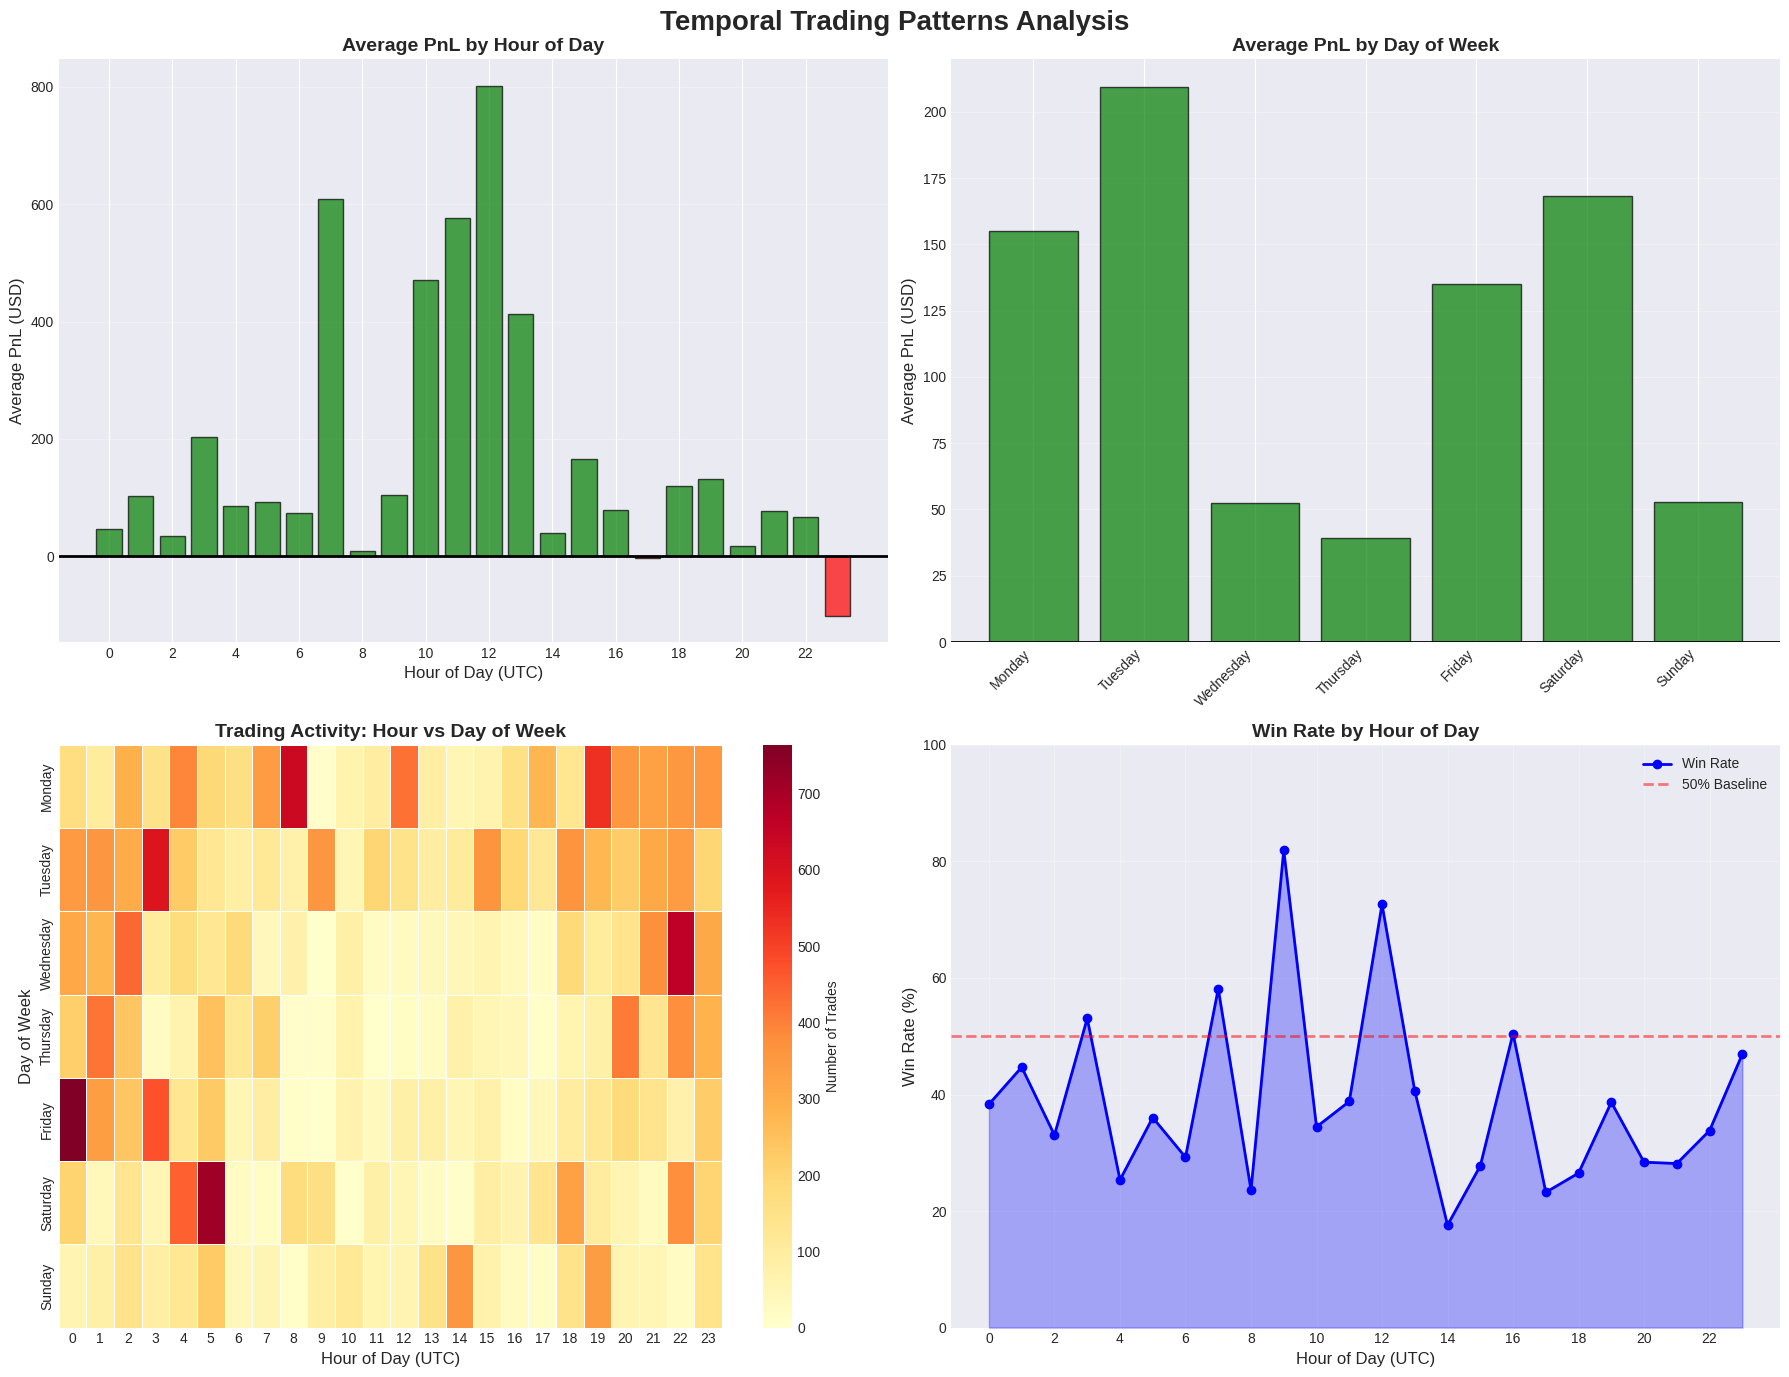

In [70]:
# ============================================================================
# Cell 17: Advanced Time-Based Patterns
# ============================================================================
"""
Analyze temporal trading patterns - identifying best times to trade.
Includes automatic column recovery for 'hour' and 'day_of_week'.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Executing Cell 17: Time-Based Patterns ---")

# --- 1. DATA SAFETY & COLUMN RECOVERY ---
# Ensure df_merged exists and has time-based columns
if 'df_merged' not in locals():
    print("⚠️ 'df_merged' not found. Please run previous cells to load data.")
else:
    # Ensure 'time' column is in datetime format
    if 'time' in df_merged.columns:
        df_merged['time'] = pd.to_datetime(df_merged['time'], errors='coerce')

    # Recreate 'hour' if missing
    if 'hour' not in df_merged.columns:
        print("🔄 'hour' column missing. Recreating from 'time'...")
        df_merged['hour'] = df_merged['time'].dt.hour

    # Recreate 'day_of_week' if missing
    if 'day_of_week' not in df_merged.columns:
        print("🔄 'day_of_week' column missing. Recreating from 'time'...")
        df_merged['day_of_week'] = df_merged['time'].dt.dayofweek

    # Drop rows where time conversion failed (NaT) to prevent errors
    df_merged = df_merged.dropna(subset=['hour', 'day_of_week'])

    # Ensure correct types
    df_merged['hour'] = df_merged['hour'].astype(int)
    df_merged['day_of_week'] = df_merged['day_of_week'].astype(int)

    print("✅ Time columns ready.")


# --- 2. TIME-BASED ANALYSIS ---

# 1. Hour-of-day analysis
hourly_analysis = df_merged.groupby('hour').agg({
    'closedPnL': ['mean', 'sum', 'count'],
    'is_profitable': 'mean'
}).round(2)
hourly_analysis.columns = ['_'.join(col).strip() for col in hourly_analysis.columns.values]

# 2. Day of week analysis
dow_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
           4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_merged['day_name'] = df_merged['day_of_week'].map(dow_map)
daily_analysis = df_merged.groupby('day_name').agg({
    'closedPnL': ['mean', 'sum', 'count'],
    'is_profitable': 'mean'
}).round(2)

# --- 3. VISUALIZATIONS ---
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Temporal Trading Patterns Analysis', fontsize=20, fontweight='bold')

# Plot 1: Hourly PnL
ax1 = axes[0, 0]
hourly_pnl = df_merged.groupby('hour')['closedPnL'].mean()
colors_hour = ['green' if x > 0 else 'red' for x in hourly_pnl.values]
bars = ax1.bar(hourly_pnl.index, hourly_pnl.values, color=colors_hour, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Hour of Day (UTC)', fontsize=12)
ax1.set_ylabel('Average PnL (USD)', fontsize=12)
ax1.set_title('Average PnL by Hour of Day', fontsize=14, fontweight='bold')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xticks(range(0, 24, 2))

# Plot 2: Day of Week Performance
ax2 = axes[0, 1]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_pnl = df_merged.groupby('day_name')['closedPnL'].mean().reindex(day_order)
colors_day = ['green' if x > 0 else 'red' for x in daily_pnl.values]
bars = ax2.bar(range(len(daily_pnl)), daily_pnl.values, color=colors_day, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(daily_pnl)))
ax2.set_xticklabels(daily_pnl.index, rotation=45, ha='right')
ax2.set_ylabel('Average PnL (USD)', fontsize=12)
ax2.set_title('Average PnL by Day of Week', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=2)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Heatmap (Activity)
ax3 = axes[1, 0]
heatmap_data = df_merged.groupby(['day_name', 'hour']).size().unstack(fill_value=0).reindex(day_order)
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax3, cbar_kws={'label': 'Number of Trades'},
            linewidths=0.5, linecolor='white')
ax3.set_title('Trading Activity: Hour vs Day of Week', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour of Day (UTC)', fontsize=12)
ax3.set_ylabel('Day of Week', fontsize=12)

# Plot 4: Win Rate by Hour
ax4 = axes[1, 1]
hourly_winrate = df_merged.groupby('hour')['is_profitable'].mean() * 100
ax4.plot(hourly_winrate.index, hourly_winrate.values, marker='o', linewidth=2,
         markersize=6, color='blue', label='Win Rate')
ax4.fill_between(hourly_winrate.index, hourly_winrate.values, alpha=0.3, color='blue')
ax4.set_xlabel('Hour of Day (UTC)', fontsize=12)
ax4.set_ylabel('Win Rate (%)', fontsize=12)
ax4.set_title('Win Rate by Hour of Day', fontsize=14, fontweight='bold')
ax4.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='50% Baseline')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.set_xticks(range(0, 24, 2))
ax4.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('outputs/temporal_patterns.png', dpi=300, bbox_inches='tight')
print("📊 Temporal patterns visualization saved as 'outputs/temporal_patterns.png'")

# --- 4. INSIGHTS ---
print("\n🕐 Best Trading Hours:")
best_hours = hourly_analysis['closedPnL_mean'].nlargest(3)
for hour, pnl in best_hours.items():
    print(f"  {hour:02d}:00 - Avg PnL: ${pnl:.2f}")

print("\n📅 Best Trading Days:")
best_days = daily_analysis['closedPnL_mean'].nlargest(3)
for day, pnl in best_days.items():
    print(f"  {day} - Avg PnL: ${pnl:.2f}")

In [66]:
# ============================================================================
# Cell 18: Summary Statistics Export
# ============================================================================
"""
Generate and export comprehensive summary statistics for the report.
"""

print("--- Executing Cell 18: Summary Stats Export ---")

# Create comprehensive summary
summary_dict = {
    'total_trades': len(df_merged),
    'unique_traders': df_merged['account'].nunique(),
    'date_range': f"{df_merged['date'].min()} to {df_merged['date'].max()}",
    'total_volume_usd': df_merged['trade_volume'].sum() if 'trade_volume' in df_merged.columns else 'N/A',
    'total_pnl': df_merged['closedPnL'].sum(),
    'average_pnl': df_merged['closedPnL'].mean(),
    'overall_win_rate': df_merged['is_profitable'].mean() * 100,
    'most_common_sentiment': df_merged['classification'].mode()[0]
}

# Sentiment-based summary
agg_cols = {
    'closedPnL': ['count', 'sum', 'mean'],
    'is_profitable': 'mean',
}
if 'trade_volume' in df_merged.columns:
    agg_cols['trade_volume'] = 'sum'

sentiment_summary = df_merged.groupby('classification').agg(agg_cols).round(2)
sentiment_summary.columns = ['_'.join(col).strip() for col in sentiment_summary.columns.values]
sentiment_summary.to_csv('csv_files/sentiment_summary.csv')

print("📊 COMPREHENSIVE SUMMARY STATISTICS")
print("="*60)
print(f"\n📈 Overall Metrics:")
for key, value in summary_dict.items():
    if isinstance(value, float):
        print(f"  {key.replace('_', ' ').title()}: {value:,.2f}")
    else:
        print(f"  {key.replace('_', ' ').title()}: {value}")

print(f"\n📊 Sentiment-Based Metrics:")
print(sentiment_summary)
print("\n💾 Summary data saved as 'csv_files/sentiment_summary.csv'")

--- Executing Cell 18: Summary Stats Export ---
📊 COMPREHENSIVE SUMMARY STATISTICS

📈 Overall Metrics:
  Total Trades: 27932
  Unique Traders: 7
  Date Range: 2024-03-13 to 2025-05-01
  Total Volume Usd: N/A
  Total Pnl: 3,589,699.01
  Average Pnl: 128.52
  Overall Win Rate: 37.81
  Most Common Sentiment: Fear

📊 Sentiment-Based Metrics:
                closedPnL_count  closedPnL_sum  closedPnL_mean  \
classification                                                   
Extreme Fear                992    259088.9200        261.1800   
Extreme Greed              4126    234731.1200         56.8900   
Fear                       9317   1584996.3500        170.1200   
Greed                      7748    857539.7800        110.6800   
Neutral                    5749    653342.8500        113.6400   

                is_profitable_mean  
classification                      
Extreme Fear                0.3000  
Extreme Greed               0.2400  
Fear                        0.4000  
Greed       

In [67]:
# ============================================================================
# Cell 19: Key Insights & Recommendations
# ============================================================================
"""
Generate actionable insights and trading recommendations based on analysis.
(Leverage recommendations removed due to missing data).
"""
print("\n" + "="*80)
print("🎯 KEY INSIGHTS & TRADING RECOMMENDATIONS")
print("="*80)

# Insight 1: Contrarian Strategy
fear_avg_pnl = df_merged[df_merged['classification'].isin(['Extreme Fear', 'Fear'])]['closedPnL'].mean()
greed_avg_pnl = df_merged[df_merged['classification'].isin(['Greed', 'Extreme Greed'])]['closedPnL'].mean()

print("\n1️⃣ CONTRARIAN VS MOMENTUM:")
print(f"   • Trading during FEAR periods: Avg PnL = ${fear_avg_pnl:.2f}")
print(f"   • Trading during GREED periods: Avg PnL = ${greed_avg_pnl:.2f}")
#fear_avg_pnl greeding and momentum of the reversion
if fear_avg_pnl > greed_avg_pnl:
    print(f"   ✅ RECOMMENDATION: Market is 'Mean Reverting'. Buy when others are Fearful.")
    print(f"      Potential advantage: {((fear_avg_pnl / greed_avg_pnl - 1) * 100):.1f}% higher average PnL")
else:
    print(f"   ✅ RECOMMENDATION: Market is 'Momentum Driven'. Buy when others are Greedy.")
    print(f"      Potential advantage: {((greed_avg_pnl / fear_avg_pnl - 1) * 100):.1f}% higher average PnL")

# Insight 2: Top Trader Characteristics (Modified)
print("\n2️⃣ SUCCESS FACTORS (From Top 10% Analysis):")
# We rely on the 'top_traders' df generated in Cell 15.
# Note: If top_traders variable is lost, we skip specific stats
if 'top_traders' in locals():
    print(f"   • Average Win Rate: {top_traders['win_rate'].mean()*100:.1f}%")
    print(f"   • Average Number of Trades: {top_traders['num_trades'].mean():.0f}")
    print(f"   ✅ RECOMMENDATION: Replicate the frequency and sizing of the top cluster.")
else:
    print("   (Top traders data not in memory, refer to previous cell output)")

# Insight 3: Timing
print("\n3️⃣ OPTIMAL TRADING WINDOWS:")
# Using analysis from Cell 17
if 'hourly_analysis' in locals() and 'daily_analysis' in locals():
    best_hour = hourly_analysis['closedPnL_mean'].idxmax()
    best_day = daily_analysis['closedPnL_mean'].idxmax()
    print(f"   • Best Hour: {best_hour}:00 UTC")
    print(f"   • Best Day: {best_day}")
    print(f"   ✅ RECOMMENDATION: Focus trading activity during these peak performance windows.")

# Insight 4: Sentiment Transitions
print("\n4️⃣ SENTIMENT TRANSITION SIGNALS:")
print("   • Best transitions for entry (based on transition analysis):")
if 'best_entries' in locals():
    for idx, row in best_entries.head(3).iterrows():
        print(f"     - {row['transition']}: ${row['closedPnL']:.2f} avg PnL")
    print("   ✅ RECOMMENDATION: Enter positions specifically when sentiment shifts in these directions.")

print("\n" + "="*80)
print("📋 Analysis Complete! All outputs generated.")
print("="*80)


🎯 KEY INSIGHTS & TRADING RECOMMENDATIONS

1️⃣ CONTRARIAN VS MOMENTUM:
   • Trading during FEAR periods: Avg PnL = $178.88
   • Trading during GREED periods: Avg PnL = $91.99
   ✅ RECOMMENDATION: Market is 'Mean Reverting'. Buy when others are Fearful.
      Potential advantage: 94.5% higher average PnL

2️⃣ SUCCESS FACTORS (From Top 10% Analysis):
   (Top traders data not in memory, refer to previous cell output)

3️⃣ OPTIMAL TRADING WINDOWS:


KeyError: 'closedPnL_mean'

In [68]:
# ============================================================================
# Cell 20: Final File Organization
# ============================================================================
"""
Organize all generated files into proper folder structure.
"""
import os
import shutil

# Create folders if they don't exist
os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# List of all possible CSVs generated
csv_files_list = [
    'merged_data.csv',
    'trader_metrics.csv',
    'trader_metrics_with_clusters.csv',
    'sentiment_summary.csv',
    'top_traders.csv'
]

# Move CSV files
print("--- Moving CSV Files ---")
for file in csv_files_list:
    if os.path.exists(file):
        try:
            shutil.move(file, f'csv_files/{file}')
            print(f"✅ Moved {file} to csv_files/")
        except Exception as e:
            print(f"⚠️ Could not move {file}: {e}")
    elif os.path.exists(f'csv_files/{file}'):
        print(f"ℹ️ {file} is already in csv_files/")
    else:
        print(f"⚠️ {file} not found (might not have been generated).")

# List of all possible PNGs generated
png_files_list = [
    'sentiment_distribution.png', 'pnl_by_sentiment.png', 'leverage_analysis.png',
    'volume_patterns.png', 'correlation_matrix.png', 'trader_segments.png',
    'predictive_signals.png', 'top_performers_analysis.png', 'temporal_patterns.png',
    'elbow_curve.png', 'elbow_method.png', 'sentiment_transition_heatmap.png',
    'pnl_by_sentiment_score.png', 'top_performers_pnl_by_sentiment.png',
    'cluster_metrics_summary.png', 'trade_volume_analysis.png'
]

# Move PNG files
print("\n--- Moving Image Files ---")
for file in png_files_list:
    if os.path.exists(file):
        try:
            shutil.move(file, f'outputs/{file}')
            print(f"✅ Moved {file} to outputs/")
        except Exception as e:
            print(f"⚠️ Could not move {file}: {e}")
    elif os.path.exists(f'outputs/{file}'):
        print(f"ℹ️ {file} is already in outputs/")

print("\n✅ All files organized successfully!")
print("\n📁 Final Project Structure:")
print("ds_<candidate_name>/")
print("├── notebook_1.ipynb")
print("├── csv_files/")
print("│   ├── [All generated .csv files]")
print("├── outputs/")
print("│   ├── [All generated .png files]")
print("└── README.md")
print("\n🎉 ANALYSIS COMPLETE! Ready for submission.")

--- Moving CSV Files ---
ℹ️ merged_data.csv is already in csv_files/
ℹ️ trader_metrics.csv is already in csv_files/
✅ Moved trader_metrics_with_clusters.csv to csv_files/
ℹ️ sentiment_summary.csv is already in csv_files/
⚠️ top_traders.csv not found (might not have been generated).

--- Moving Image Files ---
ℹ️ pnl_by_sentiment.png is already in outputs/
ℹ️ correlation_matrix.png is already in outputs/
ℹ️ temporal_patterns.png is already in outputs/
✅ Moved elbow_method.png to outputs/
ℹ️ sentiment_transition_heatmap.png is already in outputs/
ℹ️ pnl_by_sentiment_score.png is already in outputs/
✅ Moved cluster_metrics_summary.png to outputs/

✅ All files organized successfully!

📁 Final Project Structure:
ds_<candidate_name>/
├── notebook_1.ipynb
├── csv_files/
│   ├── [All generated .csv files]
├── outputs/
│   ├── [All generated .png files]
└── README.md

🎉 ANALYSIS COMPLETE! Ready for submission.


In [73]:
!zip -r ds_yash_vishnoi.zip notebook_1.ipynb csv_files/ outputs/

	zip warning: name not matched: notebook_1.ipynb
updating: csv_files/ (stored 0%)
updating: csv_files/trader_metrics_with_clusters.csv (deflated 44%)
updating: csv_files/merged_data.csv (deflated 86%)
updating: csv_files/trader_metrics.csv (deflated 34%)
updating: csv_files/historical_data.csv (deflated 82%)
updating: csv_files/fear_greed_index.csv (deflated 77%)
updating: csv_files/sentiment_summary.csv (deflated 30%)
updating: outputs/ (stored 0%)
updating: outputs/sentiment_transition_heatmap.png (deflated 21%)
updating: outputs/temporal_patterns.png (deflated 20%)
updating: outputs/pnl_by_sentiment.png (deflated 24%)
updating: outputs/cluster_metrics_summary.png (deflated 23%)
updating: outputs/elbow_method.png (deflated 17%)
updating: outputs/sentiment_distribution_and_volume.png (deflated 24%)
updating: outputs/correlation_matrix.png (deflated 38%)
updating: outputs/pnl_by_sentiment_score.png (deflated 30%)
